# Overview
Use this notebook to convert OCT 3D volume (stored in .tiff)  to virtual histology.

To get started,
[open this notebook in colab](https://colab.research.google.com/github/WinetraubLab/OCT2Hist-ModelInference/blob/main/run_oct2hist3D.ipynb) and run.


In [1]:
# @title Notebook Inputs { display-mode: "form" }
# @markdown Input Image Path
# Path to the OCT image
oct_input_volume_path = "/content/drive/Shareddrives/Yolab - Current Projects/_Datasets/2020-11-10 10x Raw Data Used In Paper (Paper V2)/LG-44/VolumeScanAbs_All.tiff" # @param {type:"string"}

# OCT image's pixel size
microns_per_pixel_z = 1
microns_per_pixel_x = 1
microns_per_pixel_y = 1

# @markdown Cropping Parameters
x0 = 0 # @param {type:"slider", min:0, max:1000, step:10}
z0 = 250 # @param {type:"slider", min:0, max:1000, step:10}

output_tiff_path = "/content/drive/Shareddrives/Yolab - Current Projects/Yonatan/Output.tif" # @param {type:"string"}
section_separation_um = 5 # @param {type:"slider", min:1, max:20, step:1}

## Set Up Environment

In [2]:
if not 'setup_env_oct2Hist_usemodel' in globals():
  setup_env_oct2Hist_usemodel = True
  !git clone --recurse-submodules https://github.com/WinetraubLab/OCT2Hist-ModelInference
  !pip install imageio
  %cd OCT2Hist-ModelInference

import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import oct2hist
from utils.show_images import *
from google.colab import drive
from utils.crop import crop
import os
import shutil
from tqdm import tqdm
drive.mount('/content/drive/')

Cloning into 'OCT2Hist-ModelInference'...
remote: Enumerating objects: 660, done.
remote: Counting objects: 100% (156/156), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 660 (delta 83), reused 150 (delta 81), pack-reused 504
Receiving objects: 100% (660/660), 23.13 MiB | 23.34 MiB/s, done.
Resolving deltas: 100% (340/340), done.
Submodule 'pytorch-CycleGAN-and-pix2pix' (https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix) registered for path 'pytorch-CycleGAN-and-pix2pix'
Cloning into '/content/OCT2Hist-ModelInference/pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2513, done.        
remote: Total 2513 (delta 0), reused 0 (delta 0), pack-reused 2513        
Receiving objects: 100% (2513/2513), 8.20 MiB | 23.84 MiB/s, done.
Resolving deltas: 100% (1575/1575), done.
Submodule path 'pytorch-CycleGAN-and-pix2pix': checked out '9f8f61e5a375c2e01c5187d093ce9c2409f409b0'
/content/OCT2Hist-ModelInference
Mounted at /content/drive/


In [3]:
# Set up the network environment
oct2hist.setup_network()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
def merge_tiff_files(input_folder, output_file):
    # Get a list of all TIFF files in the input folder
    tiff_files = [file for file in os.listdir(input_folder) if file.lower().endswith('.png')]

    # Sort the files if needed
    tiff_files.sort()

    # Open all TIFF files
    images = [Image.open(os.path.join(input_folder, file)) for file in tiff_files]

    # Save as multi-page TIFF
    images[0].save(output_file, save_all=True, append_images=images[1:])

## Run
In this step we load the OCT image, then crops it to the right size



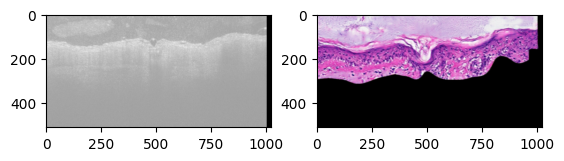

In [5]:
# @title Visualize one of the slides
# Configuration
min_signal_threshold = np.nan

# Crop
oct_image = cv2.imread(oct_input_volume_path)
cropped = crop(oct_image, target_width=1024, target_height=512, x0=x0, z0=z0)

# Run Inference
virtual_histology_image, *_ = oct2hist.run_network(
  cropped,
  microns_per_pixel_x = microns_per_pixel_x,
  microns_per_pixel_z = microns_per_pixel_z,
  min_signal_threshold = min_signal_threshold
  )

showTwoImgs(cropped, virtual_histology_image)

In [ ]:
# @title Process the rest

# Load OCT image
_, oct_volume = cv2.imreadmulti(oct_input_volume_path)
oct_volume = np.asarray(oct_volume)

# Create a temporary folder for individual scans
tmp_folder = '/content/tmp/'
if os.path.exists(tmp_folder):
    shutil.rmtree(tmp_folder)
    print(f"Folder '{tmp_folder}' deleted.")
os.makedirs(tmp_folder) # Create a new folder

# Loop over entire volume convert and append to outputfile
for i in tqdm(
    range(0,oct_volume.shape[0],int(section_separation_um/microns_per_pixel_y)),
    desc="Converting OCT to Histology", unit="image"):
  # Crop
  oct_image = cv2.cvtColor(oct_volume[i,:,:], cv2.COLOR_GRAY2BGR)
  cropped = crop(oct_image, target_width=1024, target_height=512, x0=x0, z0=z0)

  # Run Inference
  virtual_histology_image, *_ = oct2hist.run_network(
    cropped,
    microns_per_pixel_x = microns_per_pixel_x,
    microns_per_pixel_z = microns_per_pixel_z,
    min_signal_threshold = min_signal_threshold
    )

  # Save to tmp file
  filepath = tmp_folder + "{0:04}.png".format(i)
  bgr_image = cv2.cvtColor(virtual_histology_image, cv2.COLOR_RGB2BGR)
  cv2.imwrite(filepath, bgr_image)

# Combine files to one volume
print('Exporting file to: ' + output_tiff_path)
merge_tiff_files(tmp_folder,output_tiff_path)

Converting OCT to Histology:   4%|▍         | 8/200 [00:36<14:53,  4.66s/image]